In [1]:
import torch
from torch.distributions import StudentT,Normal,Laplace,Gamma, Bernoulli, Categorical, Beta
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from random import sample,seed

In [2]:
from causal_cocycle.model import cocycle_model,flow_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Constant_Conditioner, Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [3]:
# Helper functions
class HSplus:
    def __init__(self,alpha=1.0):
        self.alpha = alpha
        
    def sample(self, shape):
        lmbda = StudentT(self.alpha,0,1).sample(shape)
        lmbda = StudentT(self.alpha,0,lmbda.abs()).sample()
        
        return Normal(0,lmbda.abs()).sample()

class HSDist:
    def __init__(self,alpha=1.0):
        self.alpha = alpha
        
    def sample(self, shape):
        lmbda = StudentT(self.alpha,0,1).sample(shape)
        return Normal(0,lmbda.abs()).sample()

class NBP:
    def __init__(self,alpha=1.0):
        self.alpha = alpha
        
    def sample(self, shape):
        lmbda = Beta(self.alpha,self.alpha).sample(shape)
        return Normal(0,lmbda/(1-lmbda)).sample()
        

class MixtureDist:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Bernoulli(0.5).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*NBP(0.1).sample(shape).abs()
        return +B*N - (1-B)*C

class MixtureDist2:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Bernoulli(0.5).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*StudentT(1,0,1).sample(shape).abs()
        return +B*N - (1-B)*C

class MixtureDist3:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/3,1/3,1/3])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*Normal(0,1).sample(shape).abs()  
        return (B==0)*(N+1) + (B==1)*(-(C+1)) + (B==2)*0
            
class MixtureDist4:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/4,1/4,1/4,1/4])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*StudentT(1,0,1).sample(shape).abs()  
        return (B==0)*(N+1) + (B==1)*(-(C+1)) + (B==2)*-0.5 + (B==3)*0.5

class likelihood_loss:
    
    def __init__(self,dist):
        self.dist = dist
        if hasattr(dist,'df'):
            self.parameters = self.dist.df.requires_grad_(True)
        else:
            self.parameters = torch.tensor(1.0)
        self.loss_fn = "MLE"
    
    def __call__(self,model,inputs,outputs):
        U,logdet = model.inverse_transformation(inputs,outputs)
        
        return torch.mean(-self.dist.log_prob(U) - logdet) 

from scipy.special import hyperu

def log_mixed_tails_density(y, a, b):
    """
    Evaluate the log-density (dropping additive constants independent of y)
    for the mixed-tails model.
    
    For y < 0, we use the Normal-Beta-Prime density evaluated at |y|:
      log p(y) ∝ (a - 0.5) * log((|y|^2)/2) + log( hyperu(a+b, a+0.5, (|y|^2)/2) )
    
    For y >= 0, we use the half-normal density:
      log p(y) ∝ -y^2/2.
    
    Parameters:
    -----------
    y : array_like
        Points at which to evaluate the log-density.
    a : float
        Parameter a of the BetaPrime part.
    b : float
        Parameter b of the BetaPrime part.
    
    Returns:
    --------
    log_density : array_like
        The log-density (up to an additive constant) evaluated at y.
    """
    y = np.asarray(y)
    log_density = np.empty_like(y)
    
    # For y < 0, use the Normal-Beta-Prime formulation.
    neg = (y < 0)
    if np.any(neg):
        x = np.abs(y[neg])
        # Compute log-density (dropping constant terms)
        log_density[neg] = (a - 0.5) * np.log(x**2 / 2.0) \
                           + np.log(hyperu(a + b, a + 0.5, x**2 / 2.0))
    
    # For y >= 0, use the half-normal density (dropping constant terms).
    pos = ~neg
    if np.any(pos):
        log_density[pos] = - y[pos]**2 / 2.0

    # Removing infs
    log_density = log_density[~(log_density==np.inf)]
    return log_density

In [4]:
# Experimental settings
n = 1000 # training samples
d = 1 # input dims
trials = 1 # experiment replications
ngrid = 100 # grid points for CATE
zlist = torch.linspace(-2,2,ngrid)[:,None]/d**0.5 # grid generation for CATE
sd = 1.0 # \sigma^2 on Y|X,Z
mc_samples = 10**5 # MC samples to approx expectations
rng = 1

# Interventions
intervention_hard = lambda a,x : a + x*0
intervention_shift = lambda a,x : a + x
intervention_scale = lambda a,x : a*x
interventions = [intervention_shift]

In [5]:
# Training set up
train_val_split = 1
ntrain = int(n)
learn_rate = [1e-2]
scheduler = False
val_tol = 1e-3
batch_size = 128
val_loss = False
maxiter = 5000
miniter = 5000
RQS_bins = 8
df_init = 10.0

# Model names
Models = ["True", "Parametric", "G-RQS SCM","L-RQS SCM", "TA-RQS SCM"]

# Models
SCM_models = []

tail_adapt = [False,False,False,False, True]

# Intervention_level
a = torch.tensor([1.0])

grad = False

In [6]:
# Estimated CATEs
CATEs_param_est = torch.zeros(len(Models),len(interventions),trials,ngrid)
for t in range(trials):
    
    # Seed set
    seed(rng + t)
    torch.manual_seed(rng + t)
    
    # Getting sample data
    #U = NBP(0.01).sample((n,1)).detach()
    #U = HSDist(0.1).sample((n,1)).detach()
    #U = StudentT(1,0,1).sample((n,1)).detach()
    U = MixtureDist(1.0).sample((n,1)).detach()
   # U = Bernoulli(0.5).sample((n,1)).detach()
    # base distributions
    SCM_base_distributions = [
        #MixtureDist(1.0),
        #Bernoulli(0.5),
        MixtureDist(1.0),
        MixtureDist(1.0),
        #StudentT(1,0,1),
        #HSDist(0.1),
        #NBP(0.01),
        Normal(0,1),
        Laplace(0,1),
        StudentT(df_init, 0,1)
    ]

    # Parametric approx
    sigma_list = 1.1**np.linspace(-100,100,1000)
    lls = np.zeros(1000)
    i=0
    for s in sigma_list:
        lls[i]=log_mixed_tails_density(U.numpy()/s,0.1,0.1).mean()-np.log(s)
        if lls[i]==np.inf:
            lls[i] =-np.inf
        i +=1
    scale_best = sigma_list[np.where(lls==lls.max())[0]]
    print(scale_best)

    # Transformers and conditioners
    SCM_conditioners = [
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1)*scale_best)-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))*1.0),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))*1.0),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))*1.0),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
    ]
    SCM_transformers = [
        Transformer([Scale_layer()],logdet = True),
        Transformer([Scale_layer()],logdet = True),
        Transformer([Shift_layer(),Scale_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([Shift_layer(),Scale_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([Shift_layer(),Scale_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
    ]
    
    # Model estimation
        
    # Getting input-output pairs
    inputs_train,outputs_train = U,U
    inputs_val,outputs_val = [],[]

    # SCM training
    for m in range(len(Models)):
        loss_fn = likelihood_loss(dist = SCM_base_distributions[m])
        model = flow_model(SCM_conditioners[m],SCM_transformers[m])
        if m > 1:
            model.transformer.logdet = True
            optimise(model,
                          loss_fn,
                          inputs_train,
                          outputs_train,
                          inputs_val,
                          outputs_val, 
                          batch_size = batch_size,
                          learn_rate = learn_rate,
                          print_ = True,
                          plot = False, 
                          miniter = miniter,
                          maxiter = maxiter, 
                          val_tol = val_tol,
                          val_loss = val_loss,
                          scheduler = scheduler,
                          likelihood_param_opt = True)
        model.transformer.logdet = False
        SCM_models.append(model)

        if tail_adapt[m]:
            SCM_base_distributions[m] = StudentT(SCM_base_distributions[m].df.detach(),0,1)
    
    print(t)

Training loss last 10 avg is : tensor(3.6435)
99.8  % completion
0


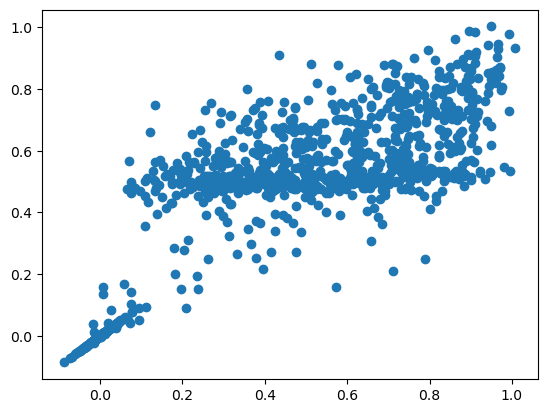

In [7]:
X = Normal(0,1).sample((n,1))
Z = Normal(0,1).sample((n,1))
Y,Y0 = torch.sigmoid(X+U)+0.025*Z, torch.sigmoid(0.0*X + U) + 0.025*Z
plt.scatter(Y,Y0)

In [8]:
basepred = SCM_base_distributions[1].sample((mc_samples,1))
torch.sigmoid(SCM_models[1].transformation(basepred,basepred).detach()).shape

torch.Size([100000, 1])

In [9]:
Xi = Normal(0,1).sample((mc_samples,1))

Y0pred = []
for m in range(len(Models)):
    basepred = SCM_base_distributions[m].sample((mc_samples,1))
    Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach())+ 0.025*Xi)
Y0pred.append(Y0pred[0][:n])

In [10]:
# Interventional Distribution Construction + Evaluation
int_levels = torch.linspace(0,0,1)
t = 0
KSDs = torch.zeros((len(Models)+1,len(int_levels),trials))
Means = torch.zeros((len(Models)+1,len(int_levels),trials))
for i in range(len(int_levels)):

    # Int sampling
    Y0pred = []
    for m in range(len(Models)):
        basepred = SCM_base_distributions[m].sample((mc_samples,1))
        Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach() + 0.00*X)+ 0.025*X)
        Means[m,i,t] = Y0pred[m].mean()
    Y0pred.append(Y0pred[0][:n])
    Means[-1,i,t] = Y0pred[m].mean()

    # CDF Construction + Storage
    eps = torch.linspace(0,1,100)[None]
    cdfs = []
    for m in range(len(Models)+1):
        cdfs.append((Y0pred[m]<=eps).float().mean(0))
        KSDs[m,i,t] = (cdfs[0]-cdfs[m]).abs().max()

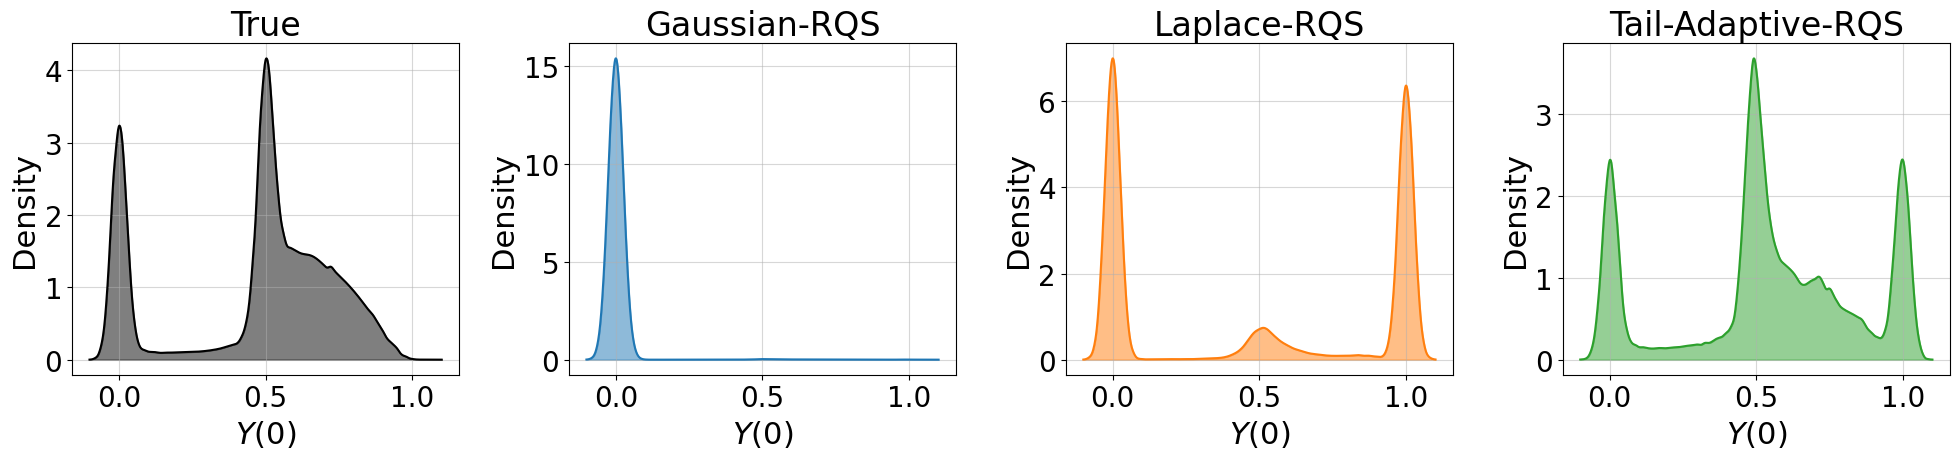

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from ssvkernel import *
# Update rcParams for global font size settings
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

plot_names = ["True", "Gaussian-RQS", "Laplace-RQS", "Tail-Adaptive-RQS"]
colours = ["black"] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_select = [0, 2, 3, 4]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(len(model_select)):
    data = Y0pred[model_select[i]][:, 0].numpy()  # Assuming Y0pred is defined elsewhere
    x = np.linspace(-0.1, 1.1, 1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')  # Assuming ssvkernel is defined
    axs[i].plot(x, y[0], color=colours[i])
    axs[i].fill_between(x, 0 * y[0], y[0], alpha=0.5, color=colours[i])
    axs[i].set_xlabel(r"$Y(0)$", fontsize=22)
    axs[i].set_ylabel("Density", fontsize=22)
    axs[i].set_title(plot_names[i], fontsize=24)  # Assuming Models is defined
    axs[i].tick_params(axis='both', which='major', labelsize=20)

     # Set y-axis tick formatter to 0 decimal places
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

    # Optional gridlines
    axs[i].grid(alpha = 0.5)
fig.tight_layout()
fig.savefig("Tailmisspec_example", bbox_inches="tight")

In [ ]:
# Checking Gauss likelihood
Utrain = U
Lik = likelihood_loss(Normal(0,1))
SCM_models[2].transformer.logdet = True

# Changing Gauss map
from copy import deepcopy
i = 7
width_shift = 0.8601
height_shift = 0
G_model = deepcopy(SCM_models[2])
G_model.conditioner[2].params = G_model.conditioner[2].params.detach()
G_model.conditioner[2].params[:,i] += width_shift
G_model.conditioner[2].params[:,i+RQS_bins] += height_shift
print(Lik(SCM_models[2],Utrain,Utrain),Lik(G_model,Utrain,Utrain))
SCM_models[2].transformer.logdet = False
G_model.transformer.logdet = False

# Plotting maps + transformed maps
ytest = torch.linspace(-4,4,1000)[:,None]
plt.plot(ytest,torch.sigmoid(SCM_models[2].transformation(ytest,ytest).detach()), lw = 3, label = r"$N(0,1)$ base", color = "C0", alpha = 1.0, zorder = 11)
#plt.plot(ytest,G_model.transformation(ytest,ytest).detach(), color = "C0", lw = 4.0, ls = "dotted", zorder = 10)
plt.plot(ytest,torch.sigmoid(SCM_models[3].transformation(ytest,ytest).detach()), lw = 3, label = r"$Lap(0,1)$ base", color = "C1", alpha = 1.0)
#plt.plot(ytest,SCM_models[3].transformation(ytest,ytest-2.0).detach(), lw = 4.0, ls = "dotted", color = "C1", zorder = 0)

#plt.scatter(SCM_models[2].inverse_transformation(Utrain,Utrain).detach(),torch.sigmoid(Utrain), s = 100, color = "C0", zorder = 100, alpha = 0.1)
#plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach(),torch.sigmoid(Utrain), s = 100, color = "C1", zorder = 100, alpha = 0.1)

# generating samples
gsample = SCM_base_distributions[2].sample((1000,))
lsample = SCM_base_distributions[3].sample((1000,))
plt.scatter(gsample,torch.sigmoid(SCM_models[2].transformation(gsample,gsample).detach()), s = 100, color = "C0", zorder = 100, alpha = 0.1)
plt.scatter(lsample,torch.sigmoid(SCM_models[3].transformation(lsample,lsample).detach()), s = 100, color = "C1", zorder = 100, alpha = 0.1)
plt.plot(SCM_base_distributions[2].cdf(cdfs[0]), torch.linspace(0,1,10000), lw = 3, ls = "dashed")
plt.plot(SCM_base_distributions[3].cdf(cdfs[0]), torch.linspace(0,1,10000), lw = 3, ls = "dotted")

#plt.scatter(G_model.inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 0.75)
#plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach()+2.0,Utrain, s = 100, color = "C1", zorder = 100, alpha = 0.75)


plt.xlabel(r"$\xi$")
plt.ylabel(r"$T_{0,0}(\xi)$")
#plt.xscale("log")
#plt.yscale("log")
plt.xlim(-10,10)
plt.ylim(0,1)
plt.legend(fontsize = 17)
plt.grid(zorder = 10)

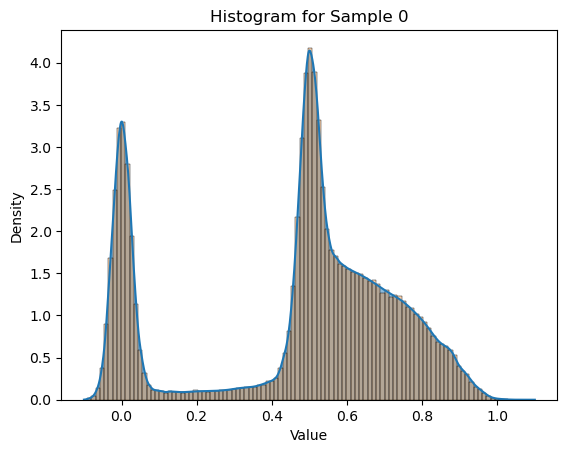

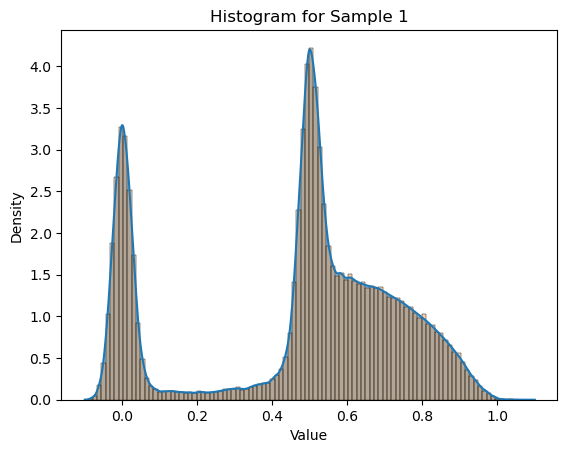

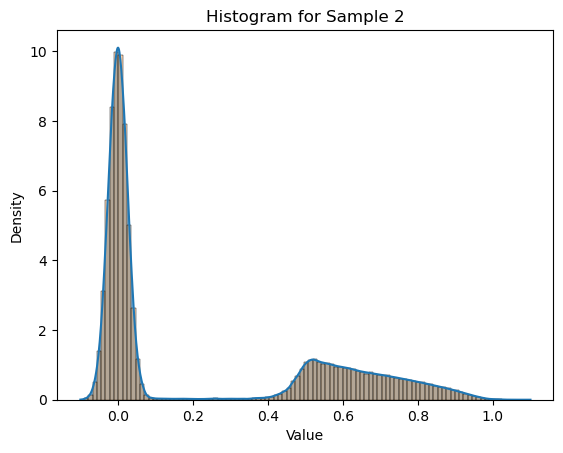

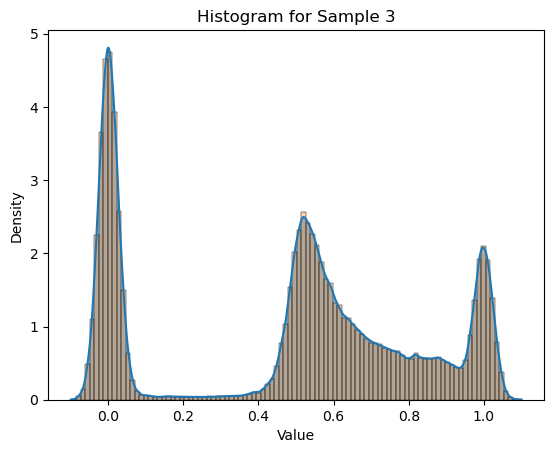

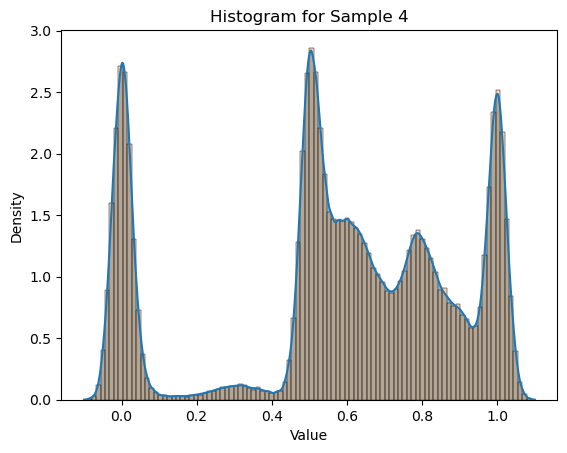

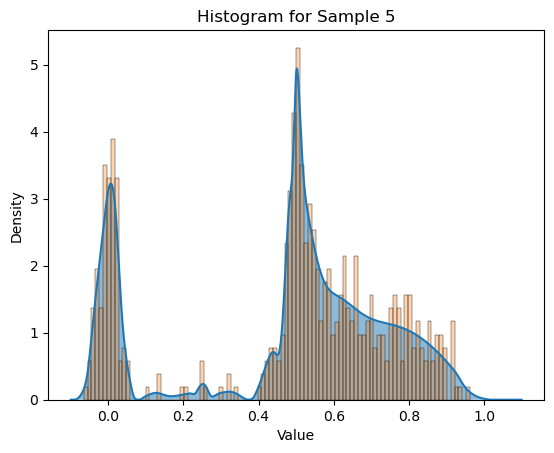

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


for i in range(len(Models)+1):
    data = Y0pred[i][:, 0].numpy()
    x = np.linspace(-0.1,1.1,1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    plt.plot(x,y[0])
    plt.fill_between(x,0*y[0],y[0], alpha = 0.5)    
    sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Histogram for Sample {i}")
    plt.show()

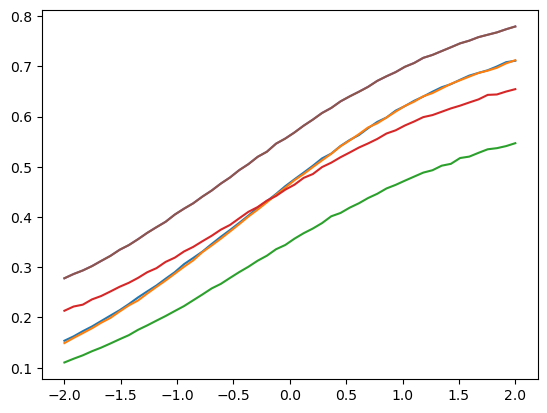

In [44]:
plt.plot(int_levels, Means[...,-1].T);

In [57]:
t = torch.linspace(0,1,10000)[None]
cdfs = []
for i in range(len(Models)+1):
    cdfs.append((Y0pred[i]<=t).float().mean(0))
    plt.plot(cdfs[i])
plt.show()

for i in range(len(Models)+1):
    print((cdfs[0]-cdfs[i]).abs().mean())

for i in range(len(Models)+1):
    print((cdfs[0]-cdfs[i]).abs().max())

for i in range(len(Models)+1):
    plt.plot((cdfs[0]-cdfs[i]).abs())

KeyboardInterrupt: 